In [38]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
hotels = pd.read_csv('hotels.csv')
display(hotels.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

In [40]:
# Создание признака город и страна 
def extract_city_country(address): # Регулярное выражение для поиска двух последних слов как город и страну

    match = re.search(r'(\b\w+\b)\s+(\b\w+\b)$', address)
    if match:
        city, country = match.groups()
        return city, country
    return None, None

# Применяем функцию к каждому адресу
hotels['city'], hotels['country'] = zip(*hotels['hotel_address'].apply(extract_city_country))


In [41]:
# Создание признаков год, месяц, день ...
hotels['review_date'] = pd.to_datetime(hotels['review_date'], errors='coerce')

hotels['year'] = hotels['review_date'].dt.year             
hotels['month'] = hotels['review_date'].dt.month           
hotels['day'] = hotels['review_date'].dt.day               
hotels['day_of_week'] = hotels['review_date'].dt.dayofweek        
hotels['is_weekend'] = hotels['day_of_week'].isin([5, 6])   # Признак выходного дня (True/False)

# Определяем сезон по месяцу
def season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

hotels['season'] = hotels['month'].apply(season)


# Проверка результата
#display(hotels[['review_date', 'year', 'month', 'day', 'day_of_week', 'is_weekend', 'season']].head())

In [42]:
def rev_func(num_tags):
    # Убираем лишние символы и разбиваем строку на теги
    num_tags = num_tags[2:-2]  # Убираем символы '[' и ']'
    res = num_tags.strip().split("', '")  # Разделяем строку на отдельные теги
    return res

# Применяем функцию, чтобы получить списки тегов
hotels['tags_n'] = hotels['tags'].apply(rev_func)

exploded_tags = hotels.explode('tags_n')

unique_tags = exploded_tags['tags_n'].str.strip().nunique()

print(f'Количество уникальных тегов: {unique_tags}')

# Убираем лишние пробелы в тегах
hotels['tags_n'] = hotels['tags_n'].apply(lambda x: [tag.strip() for tag in x])

# Пересчитываем количество тегов для каждого отзыва
hotels['num_tags'] = hotels['tags_n'].apply(len)

# Признак наличия популярных тегов, например, 'Leisure trip' или 'Couple'
hotels['is_leisure_trip'] = hotels['tags_n'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
hotels['is_couple'] = hotels['tags_n'].apply(lambda x: 1 if 'Couple' in x else 0)

# Признак для деловых поездок
hotels['is_business_trip'] = hotels['tags_n'].apply(lambda x: 1 if any(tag in x for tag in ['Business trip', 'Solo traveler']) else 0)

# Проверка результата
#display(hotels[['tags', 'num_tags', 'is_leisure_trip', 'is_couple', 'is_business_trip']].head())

Количество уникальных тегов: 2368


In [43]:
# удаление стобцов типа String, object
colums_to_drop = ["hotel_address", "review_date", "reviewer_nationality", "hotel_name",
"negative_review", "positive_review", "tags", "days_since_review", 'tags_n']

hotels = hotels.drop(columns= colums_to_drop)

In [44]:
# Кодирование признака city
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

city_encoded = encoder.fit_transform(hotels[['city']])

# Создаем датафрейм из закодированных значений
city_encoded_df = pd.DataFrame(city_encoded, columns=encoder.get_feature_names_out(['city']))

# Объединяем закодированный признак с исходным датафреймом
hotels = pd.concat([hotels, city_encoded_df], axis=1)

hotels = hotels.drop(columns=['city'])

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [45]:
# Кодирование признака country
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

city_encoded = encoder.fit_transform(hotels[['country']])

# Создаем датафрейм из закодированных значений
city_encoded_df = pd.DataFrame(city_encoded, columns=encoder.get_feature_names_out(['country']))

# Объединяем закодированный признак с исходным датафреймом
hotels = pd.concat([hotels, city_encoded_df], axis=1)

hotels = hotels.drop(columns=['country']) 

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [46]:
# Кодирование признака season
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

city_encoded = encoder.fit_transform(hotels[['season']])

# Создаем датафрейм из закодированных значений
city_encoded_df = pd.DataFrame(city_encoded, columns=encoder.get_feature_names_out(['season']))

# Объединяем закодированный признак с исходным датафреймом
hotels = pd.concat([hotels, city_encoded_df], axis=1)

hotels = hotels.drop(columns=['season'])

hotels['is_weekend'] = hotels['is_weekend'].astype(int)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [47]:
hotels.info()
display(hotels.columns)
hotels = hotels.fillna(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   lat                                         384355 non-null  float64
 8   lng                                         384355 non-null  float64
 9   year                                        386803 non-null  int32  
 

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat',
       'lng', 'year', 'month', 'day', 'day_of_week', 'is_weekend', 'num_tags',
       'is_leisure_trip', 'is_couple', 'is_business_trip', 'city_Amsterdam',
       'city_Barcelona', 'city_Milan', 'city_Paris', 'city_United',
       'city_Vienna', 'country_Austria', 'country_France', 'country_Italy',
       'country_Kingdom', 'country_Netherlands', 'country_Spain',
       'season_autumn', 'season_spring', 'season_summer', 'season_winter'],
      dtype='object')

In [48]:
# Список числовых признаков
numeric_features = [
    'additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts',
    'total_number_of_reviews', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat', 'lng', 'year', 'month', 'day', 'day_of_week',  'num_tags']

# Список категориальных признаков 
categorical_features = ['is_leisure_trip', 'is_couple', 'is_business_trip', 'city_Amsterdam',
       'city_Barcelona', 'city_Milan', 'city_Paris', 'city_United',
       'city_Vienna', 'country_Austria', 'country_France', 'country_Italy',
       'country_Kingdom', 'country_Netherlands', 'country_Spain',
       'season_autumn', 'season_spring', 'season_summer', 'season_winter']

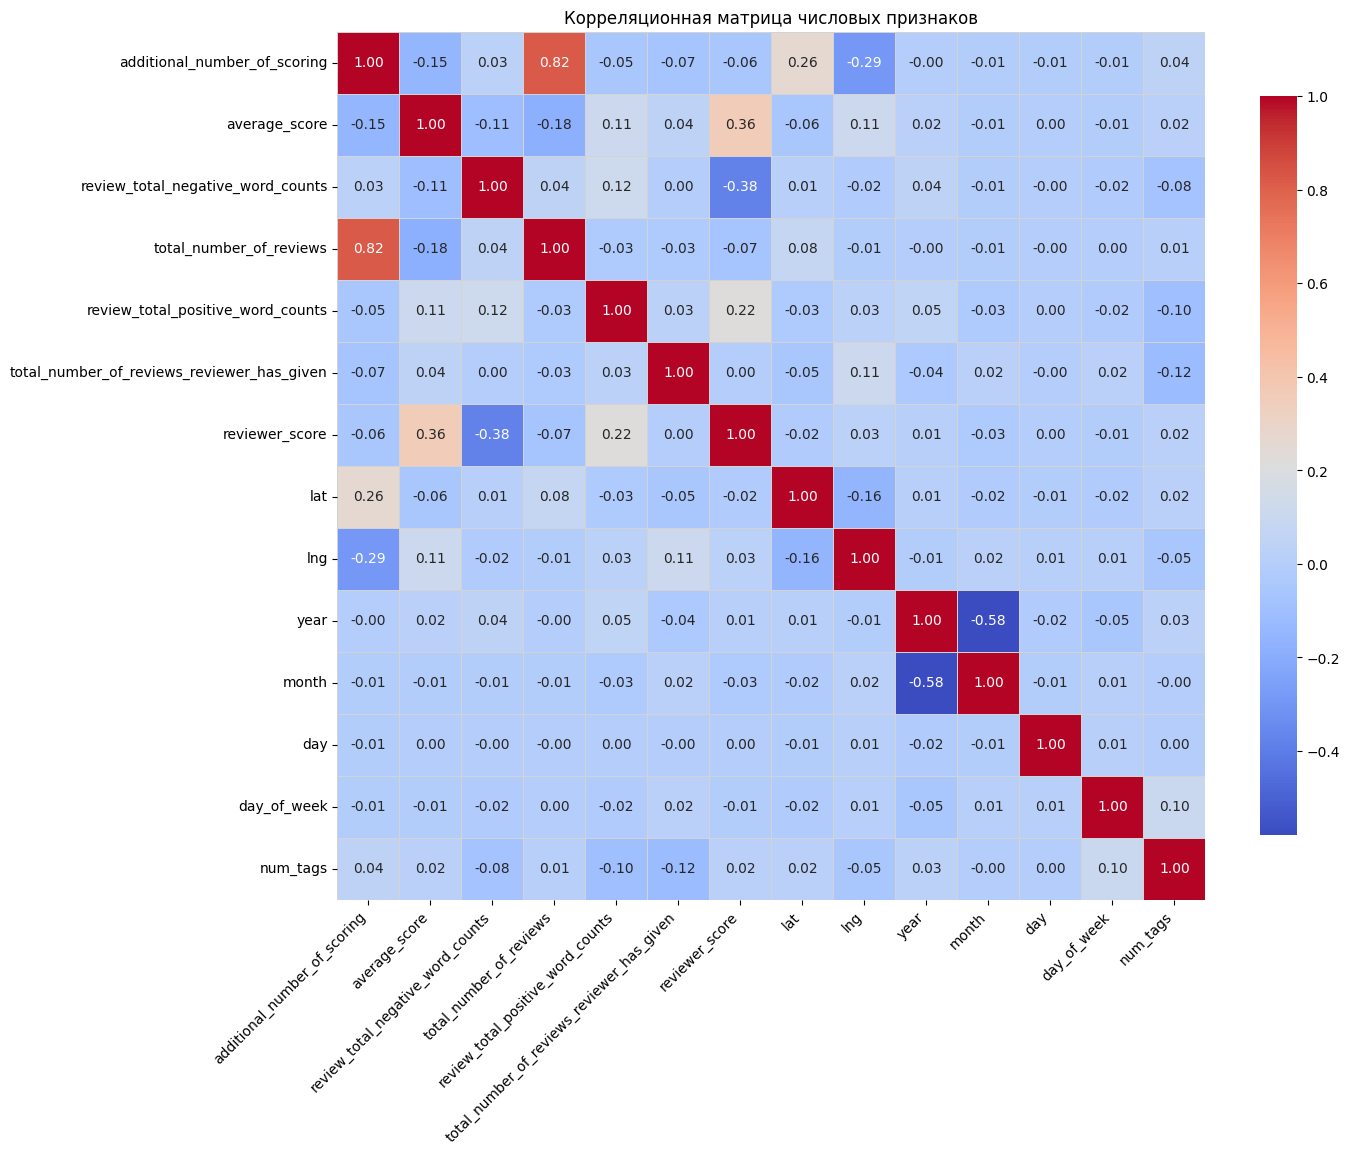

In [49]:
def numeric_features_mlt(numeric_features):
    # Выделяем числовые признаки
    numeric_features = hotels[numeric_features]

    # Рассчитываем корреляционную матрицу
    correlation_matrix = numeric_features.corr(method='pearson')

    # Округляем значения корреляции для улучшения читаемости
    correlation_matrix = correlation_matrix.round(2)

    # Настраиваем размер графика и палитру
    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'shrink': .8}, square=True, linewidths=0.5, linecolor='lightgrey', annot_kws={"size": 10})
    plt.title("Корреляционная матрица числовых признаков")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

numeric_features_mlt(numeric_features=numeric_features)

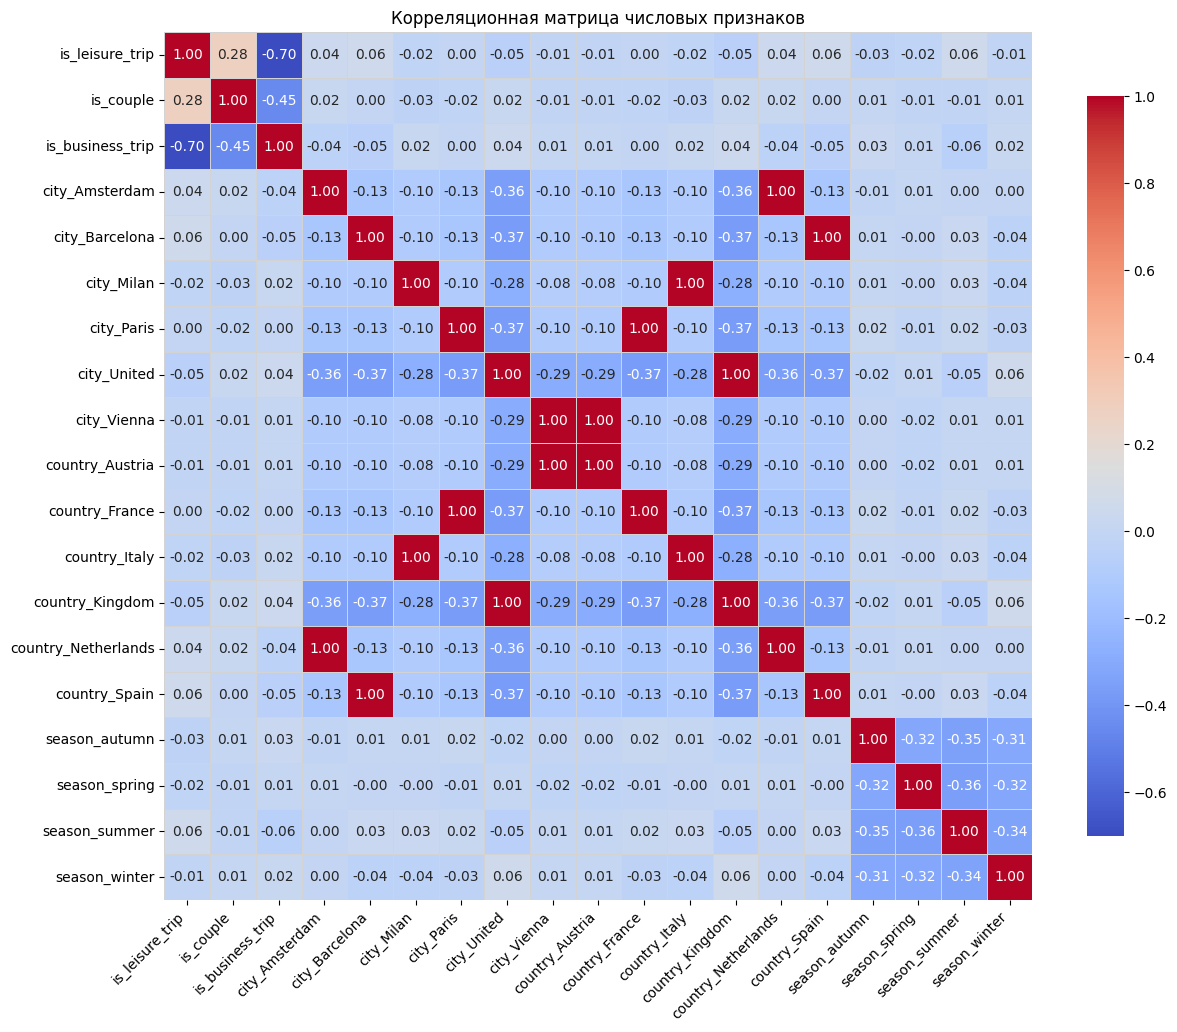

In [50]:
def categorical_features_mlt(categorical_features):
    # Выделяем категориальные признаки
    numeric_features = hotels[categorical_features]

    # Рассчитываем корреляционную матрицу
    correlation_matrix = numeric_features.corr(method='spearman')

    # Округляем значения корреляции для улучшения читаемости
    correlation_matrix = correlation_matrix.round(2)

    # Настраиваем размер графика и палитру
    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'shrink': .8}, square=True, linewidths=0.5, linecolor='lightgrey', annot_kws={"size": 10})
    plt.title("Корреляционная матрица числовых признаков")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()
categorical_features_mlt(categorical_features=categorical_features)

In [51]:

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [52]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [53]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [54]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [55]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1365245985953868
